# Deep Learning Programming Ex 02: Multi-Class SVM

In this exercise you will:

- Build the general architecture of a multi-class SVM, including:
    - Calculating the cost function and its gradient
    - Find the optimal hyperparameters by cross validation

Instruction:

- Run each cell and read the comments carefully (in the right order)
- Implement the missing codes that are required

# Load Required Libraries [0pt]

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time

## CIFAR-10 load data [0pt]

Run the next cell to define a data helper function that does some basic preprocessing.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../data/cifar/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Task 1: Multi-Class SVM - Loss Function and Gradients [5pt]

Complete the implementation of svm_loss_naive by implementing a naive analytical gradient descent that uses nested loops.

In [3]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero
    num_classes = W.shape[1]
    num_samples = X.shape[0]

    #############################################################################
    # TODO: Compute the multi-class svm loss and its gradient using explicit    #
    # loops. Store the loss in loss and the gradient in dW. Don't forget the    #
    # regularization!                                                           #
    #############################################################################

    loss = 0.0
    margin = 1.0

    for i in range(num_samples):
        score = X[i].dot(W)
        corr_score = score[y[i]]

        for j in range(num_classes):
            if y[i] == j:
                continue
            condi = score[j] - corr_score + margin
            if(condi > 0):                        
                loss += condi
                dW[:,y[i]] -= X[i]
                dW[:,j] += X[i]

                

    loss /= num_samples
    dW /= num_samples
  
    loss += reg * np.sum(W * W)*0.5
    dW += reg*W

    
    #############################################################################
    #                         END OF YOUR CODE                                  #
    #############################################################################
    return loss, dW

# Check: Gradients [0pt] 

The next cell is a self-check for you to make sure your SVM implementation works!
It compares your analytical gradients to numerically calculated gradients.
The numerical and analytical values should be the same up to printing accurracy,
relative error should be smaller than $10^{-7}$.

In [4]:
# Compute the loss and its gradient at W.
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 9.456811,	analytic: 9.456811,	relative error: 5.449206e-12
numerical: -0.521001,	analytic: -0.521001,	relative error: 3.343424e-10
numerical: 32.406290,	analytic: 32.406290,	relative error: 6.023860e-12
numerical: 17.152531,	analytic: 17.152531,	relative error: 1.661855e-11
numerical: 25.044385,	analytic: 25.053144,	relative error: 1.748465e-04
numerical: 11.318550,	analytic: 11.318550,	relative error: 2.385198e-11
numerical: 17.342336,	analytic: 17.342336,	relative error: 1.641936e-12
numerical: -8.127915,	analytic: -8.127915,	relative error: 4.079697e-11
numerical: 12.002322,	analytic: 12.019054,	relative error: 6.965502e-04
numerical: 7.764880,	analytic: 7.764880,	relative error: 3.412294e-11
numerical: -18.872501,	analytic: -18.872501,	relative error: 4.893699e-12
numerical: 12.071560,	analytic: 12.071560,	relative error: 4.690551e-12
numerical: -4.253271,	analytic: -4.231845,	relative error: 2.525172e-03
numerical: 15.056449,	analytic: 15.056449,	relative error: 1.53097

# Task 2: Multi-Class SVM [5pt]

Implement a vectorized version of the SVM loss function.

In [5]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################

    num_samples = X.shape[0]
    score = X.dot(W)
    corr_score = score[np.arange(score.shape[0]),y]
    corr_score = np.reshape(corr_score, (X.shape[0], -1))

    margin = np.ones(score.shape)
    
    condi = score - corr_score + margin
    condi[np.arange(score.shape[0]),y] = 0
    condi[condi < 0] = 0
    loss = np.sum(condi)
    
    loss /= num_samples
    loss += reg * np.sum(W * W)*0.5
    
  
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################

    condi[condi > 0] = 1
    condi[np.arange(score.shape[0]),y] = -1 * np.sum(condi,axis = 1)

    dW = X.T.dot(condi)
    dW /= num_samples
    dW += reg*W

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dW

# Check: Performance Comparison [0pt]

Execute the cell below to run a performance comparison between the naive implementation using loops
and the optimized version using vectorized instructions.
The two versions should compute the same results, but the vectorized version should be much faster.

In [6]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff = tic - toc
print('Naive loss: %e computed in %fs' % (loss_naive, diff))

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff_vec = tic - toc
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, diff_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Runtime abs. difference: %f seconds' % (diff_vec - diff))
print('Runtime rel. improvement: %f percent' % (1 - (diff_vec / diff)))

Naive loss: 8.866969e+00 computed in -0.103723s
Vectorized loss: 8.866969e+00 computed in -0.033708s
Loss difference: 0.000000
Gradient difference: 0.000000
Runtime abs. difference: 0.070015 seconds
Runtime rel. improvement: 0.675018 percent


# Stochastic Gradient Descent [0pt]

You already implemented this in the last exercise. Please run the cell below to define this function in the current namespace.

In [7]:
# train multi-class svm by SGD, implemented in last assignment
def train_SGD(X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    W: A numpy array of shape (D, C) containing weights
    loss_history: A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
   
    # Generate a random softmax weight matrix
    W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
        X_batch = None
        y_batch = None
        p = np.random.choice(num_train, batch_size)
        X_batch = X[p,:]
        y_batch = y[p]
  

        # evaluate loss and gradient
        loss, grad = svm_loss_vectorized(W,X_batch, y_batch, reg)
        loss_history.append(loss)
 
        W -= learning_rate*grad

        if verbose and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return W, loss_history

# SVM Training [0pt]

Run the next cell to train a SVM classifier using stochastic gradient descent.

In [8]:
tic = time.time()
W, loss_hist = train_SGD(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('This took %fs' % (toc - tic))

iteration 0 / 1500: loss 411.715570
iteration 100 / 1500: loss 243.731409
iteration 200 / 1500: loss 147.442882
iteration 300 / 1500: loss 91.117526
iteration 400 / 1500: loss 57.405433
iteration 500 / 1500: loss 36.092636
iteration 600 / 1500: loss 23.747486
iteration 700 / 1500: loss 16.415880
iteration 800 / 1500: loss 12.169568
iteration 900 / 1500: loss 9.221275
iteration 1000 / 1500: loss 7.232635
iteration 1100 / 1500: loss 6.190983
iteration 1200 / 1500: loss 5.762342
iteration 1300 / 1500: loss 5.290655
iteration 1400 / 1500: loss 5.562233
This took 5.939124s


# Check: Prediction [0pt]

The next two cells define and run the predict function. 

In [9]:
def predict(W, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    y_pred = np.argmax(np.dot(X,W),axis=1)
    return y_pred

In [10]:
# Write the predict function and evaluate the performance on both the
# training and validation set
y_train_pred = predict(W,X_train)
print('training accuracy: %f' % np.mean(y_train == y_train_pred))
y_val_pred = predict(W,X_val)
print('validation accuracy: %f' % np.mean(y_val == y_val_pred))

training accuracy: 0.380857
validation accuracy: 0.392000


# Task 3: Hyperparameter Tuning [5pt]

Follow the instructions in the comments and run a hyperparameter tuning adapted to a SVM.

In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-8, 1e-8]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_W = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# from cs231n.classifiers import LinearSVM


for lr in learning_rates:
    for reg in regularization_strengths:
        W, loss_hist = train_SGD(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1000, verbose=True)
        train_pred =  predict(W,X_train)
        train_ac = np.mean(y_train == train_pred)
        val_pred = predict(W,X_val)
        val_ac = np.mean(y_val == val_pred)
        results[(lr, reg)] = (train_ac, val_ac)
        if(best_val < val_ac):
            best_val = val_ac
            best_W = W

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 409.008767
iteration 100 / 1000: loss 244.233364
iteration 200 / 1000: loss 148.526994
iteration 300 / 1000: loss 91.983394
iteration 400 / 1000: loss 56.522681
iteration 500 / 1000: loss 36.087283
iteration 600 / 1000: loss 23.969540
iteration 700 / 1000: loss 16.447731
iteration 800 / 1000: loss 12.095388
iteration 900 / 1000: loss 9.059795
iteration 0 / 1000: loss 781.065609
iteration 100 / 1000: loss 284.965591
iteration 200 / 1000: loss 106.800077
iteration 300 / 1000: loss 42.078901
iteration 400 / 1000: loss 19.091795
iteration 500 / 1000: loss 10.016716
iteration 600 / 1000: loss 7.554132
iteration 700 / 1000: loss 6.265737
iteration 800 / 1000: loss 5.472833
iteration 900 / 1000: loss 5.779582
iteration 0 / 1000: loss 410.868049
iteration 100 / 1000: loss 311.896826
iteration 200 / 1000: loss 242.491142
iteration 300 / 1000: loss 190.147466
iteration 400 / 1000: loss 148.111684
iteration 500 / 1000: loss 116.436071
iteration 600 / 1000: loss 91.149400


# Check: Test Accuracy and Weight Visualization [0pt]

Run the next cell to try your SVM implementation on unseen test data. Accuracy should be around 0.35.
The last cell displays the (rescaled) weights your SVM has learned for each class.

In [12]:
# Evaluate the best svm on test set
y_test_pred = predict(best_W,X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.363000


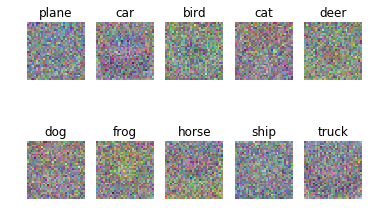

In [13]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])